# Определение возраста покупателей

**Описание проекта**
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя. 

**Цель:** Построить модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

### Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Размер выборки

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего 7591 изображений.

### Распределение по возрастам

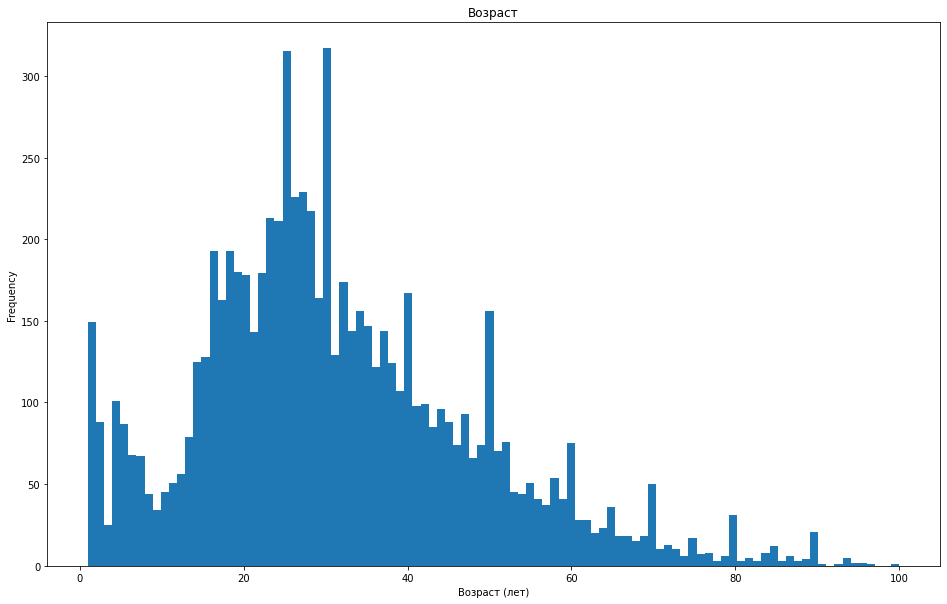

In [4]:
labels['real_age'].plot.hist(bins=100, title='Возраст', figsize=(16,10)).set_xlabel("Возраст (лет)");

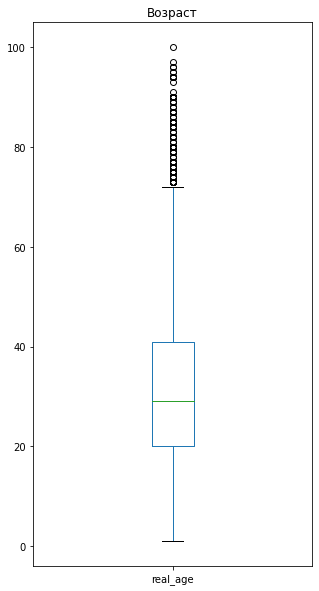

In [5]:
labels['real_age'].plot(kind='box', title='Возраст', figsize=(5,10));

Основной массив данных о людях в возрасте от 18 до 40 лет.

### Примеры фотографий

In [6]:
images, ages = next(train_gen_flow)

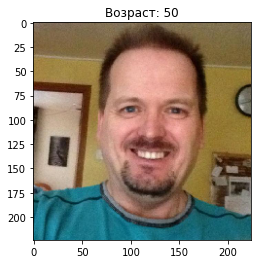

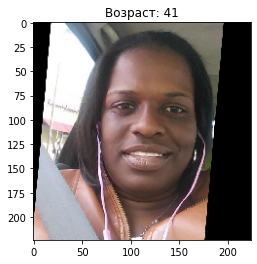

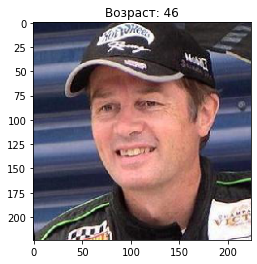

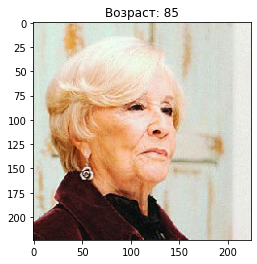

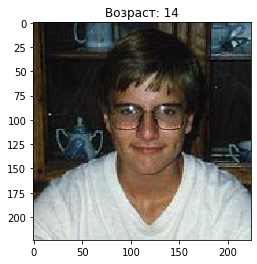

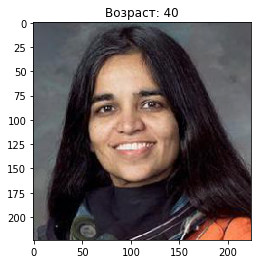

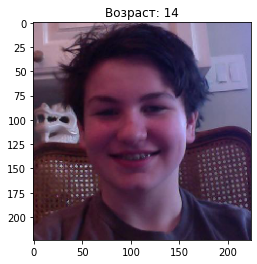

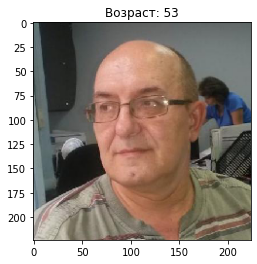

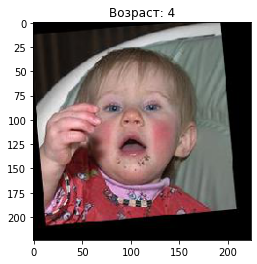

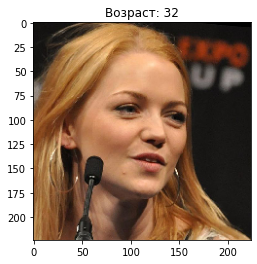

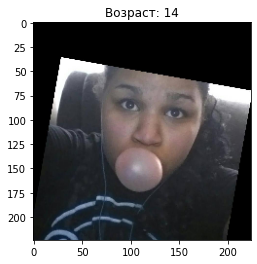

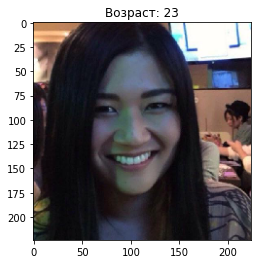

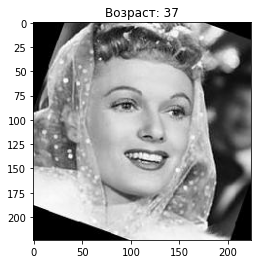

In [7]:
for image, age in zip(images[0:13], ages[0:13]):
    plt.subplots()
    plt.title(f'Возраст: {age}')
    plt.imshow(image)

**Выводы:**
1. Размер датасета по видимому достаточен для обучения сети основанной на ResNet50 без заморозки весов бэкбона, с другой стороны полносвязная верхушка сети не должна быть слишком сложной.
2. Распределение возрастов в целом довольно хорошее, однако возможно для возрастов 9-12 лет и 60+ модель будет не достаточно точной из за относительно малого количества примеров.
3. Фотографии довольно разнообразны не только по возрасту, но и по одежде и выражени лица.
4. Для аугментации можно применить flip.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


SEED = 12345
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=SEED)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=SEED)
    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(48, activation='relu'))
    model.add(Dense(1, activation=None))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 

```

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-02-20 15:36:56.922114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-20 15:36:59.174097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 66s - loss: 226.9715 - mae: 10.6264 - val_loss: 703.9649 - val_mae: 21.5796
Epoch 2/10
178/178 - 37s - loss: 71.5740 - mae: 6.3426 - val_loss: 565.9237 - val_mae: 18.5592
Epoch 3/10
178/178 - 37s - loss: 50.5630 - mae: 5.3756 - val_loss: 285.4064 - val_mae: 12.8129
Epoch 4/10
178/178 - 37s - loss: 32.8096 - mae: 4.3770 - val_loss: 129.2512 - val_mae: 8.5348
Epoch 5/10
178/178 - 38s - loss: 25.2096 - mae: 3.8073 - val_loss: 78.8285 - val_mae: 6.7084
Epoch 6/10
178/178 - 37s - loss: 20.4972 - mae: 3.4455 - val_loss: 78.3543 - val_mae: 6.7095
Epoch 7/10
178/178 - 39s - loss: 14.8088 - mae: 2.9476 - val_loss: 66.7951 - val_mae: 6.2104
Epoch 8/10
178/178 - 40s - loss: 12.4063 - mae: 2.6892 - val_loss: 69.7973 - val_mae: 6.3071
Epoch 9/10
178/178 - 40s - loss: 11.2066 - mae: 2.5252 - val_loss: 64.7032 - val_mae: 6.0296
Epoch 10/10
178/178 - 39s - loss: 9.4765 - mae: 2.3138 - val_loss: 63.0489 - val_mae: 6.0010
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s

```

## Анализ обученной модели

**Выводы:**
1. Цель проекта достигнкта - построена регрессионная модель оценки возраста покупателя по его фоторграфии.
2. Целевое значение метрики достигнуто (MAE = 6.00 лет). Но следует отметить, что для решения второй проблемы магазина этого может оказаться недостаточно.
3. Модель немного переобучена. Может стоит сократить число нейронов в полносвязном слое.
4. Судя по кривой обучения при текущей архитектуре и настройке оптимизатора хватило бы 9 эпох.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы